In [124]:
%matplotlib inline

import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl 
import pandas as pd
import contextily as ctx
from mplcairo import operator_t
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [115]:
def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        k = txt.get_text()
        txt.set_text(mapping[int(float(k))])

In [116]:
def plot_categorical(df, column, borders, output, annotation_pos_1, annotation_pos_2, zoom):
    colors = [
    '#80b1d3',
    '#8dd3c7',
    '#b3de69',
    '#ccebc5',
    '#ffed6f',
    '#ffffb3',
    '#e68d28',
    '#fdb462',
    '#fb8072',
    '#c897c9',
    '#bc80bd',
    '#a082a1'
    ]


    fig, ax = plt.subplots()
    ax.set_facecolor('none')
    ax.set_axis_off()


    plot = df.plot(ax=ax, 
                       column=column, 
                       legend=True, 
                       cmap=mpl.colors.ListedColormap(colors),
                       categorical=True,
                       linewidth=0,
                       legend_kwds={'loc': 'lower center',
                                    'ncol': 4})
    #bairros.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=0.4, linestyle='--', alpha=0.5)
    for i, border in enumerate(borders):
        border_plot = border.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=(1.5/(i+1)), linestyle='--')

    legend_dict={1: 'Alimentação',
                 2: 'Genêros Alimentícios',
                 3: 'Artigos do Lar',
                 4: 'Artigos Diversos',
                 5: 'Conveniência',
                 6: 'Vestuário',
                 7: 'Construção',
                 8: 'Automotivo',
                 9: 'Entretenimento',
                 10: 'Serviços Diversos',
                 11: 'Serviços Pessoais',
                 12: 'Serviços Médicos',}



    replace_legend_items(ax.get_legend(), legend_dict)
    leg = ax.get_legend()
    leg.set_bbox_to_anchor((0.5, -0.065))


    #ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels, zoom=16, alpha = 1)
    ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerBackground, zoom=zoom, alpha = 0.2, attribution="")
    operator_t.MULTIPLY.patch_artist(plot)  # Use additive blending.
    plt.annotate('Base Cartográfica por Stamen Design', (0,0), annotation_pos_1, xycoords='axes fraction', textcoords='offset points', va='center')
    plt.annotate('Fonte: Prefeitura de João Pessoa, 2020', (0,0), annotation_pos_2, xycoords='axes fraction', textcoords='offset points', va='center')

    plt.tight_layout()
    plt.savefig(output, bbox_inches='tight')

In [117]:
plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.style.use('ggplot')
plt.rcParams['figure.facecolor'] = '#FFFFFF'
plt.rcParams['figure.edgecolor'] = 'red'
mpl.rcParams['legend.facecolor'] = '#FFFFFF'
mpl.rcParams['figure.edgecolor'] = 'black'
mpl.rcParams['legend.loc'] = 'lower center'

In [118]:
lotes = gpd.read_file('./data/LOTES/lotes_completo.shp')
recorte_maior = gpd.read_file('./data/BASES/limite_recorte/limite_recorte_maior.shp')
recorte_menor = gpd.read_file('./data/BASES/limite_recorte/limite_recorte_menor.shp')

limite_mun = gpd.read_file("./data/BASES/limite_municipio/limite_municipio.shp")
recorte = recorte.to_crs(epsg=3857)
lotes = lotes.to_crs(epsg=3857)
limite_mun = limite_mun.to_crs(epsg=3857)
lotes_recorte =  gpd.overlay(lotes, recorte, how='intersection')


In [119]:
# Fill the whole, maybe move this to base
#limite_mun['geometry'][0] = Polygon(limite_mun['geometry'][0].exterior)

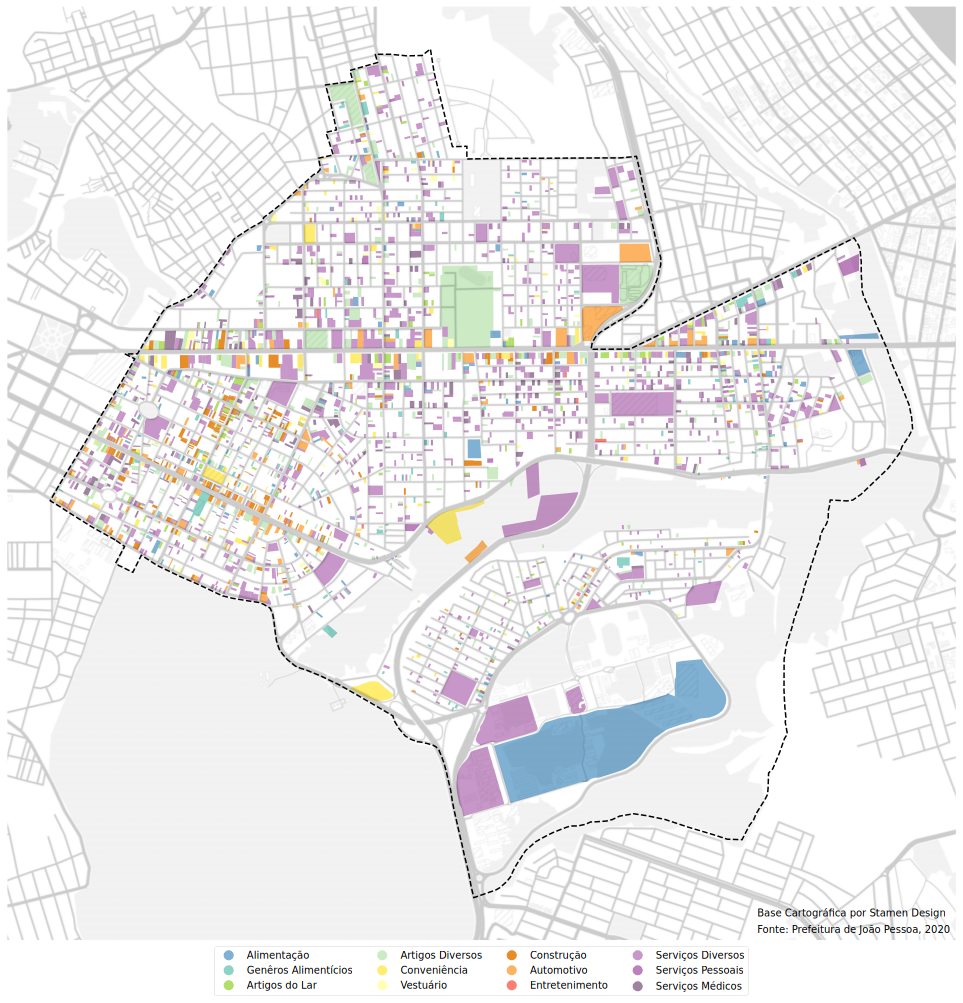

In [120]:
plot_categorical(lotes_recorte, 'classifica', [recorte_maior], 'varejo_area_recorte.pdf', (750, 27), (750, 10), 16)

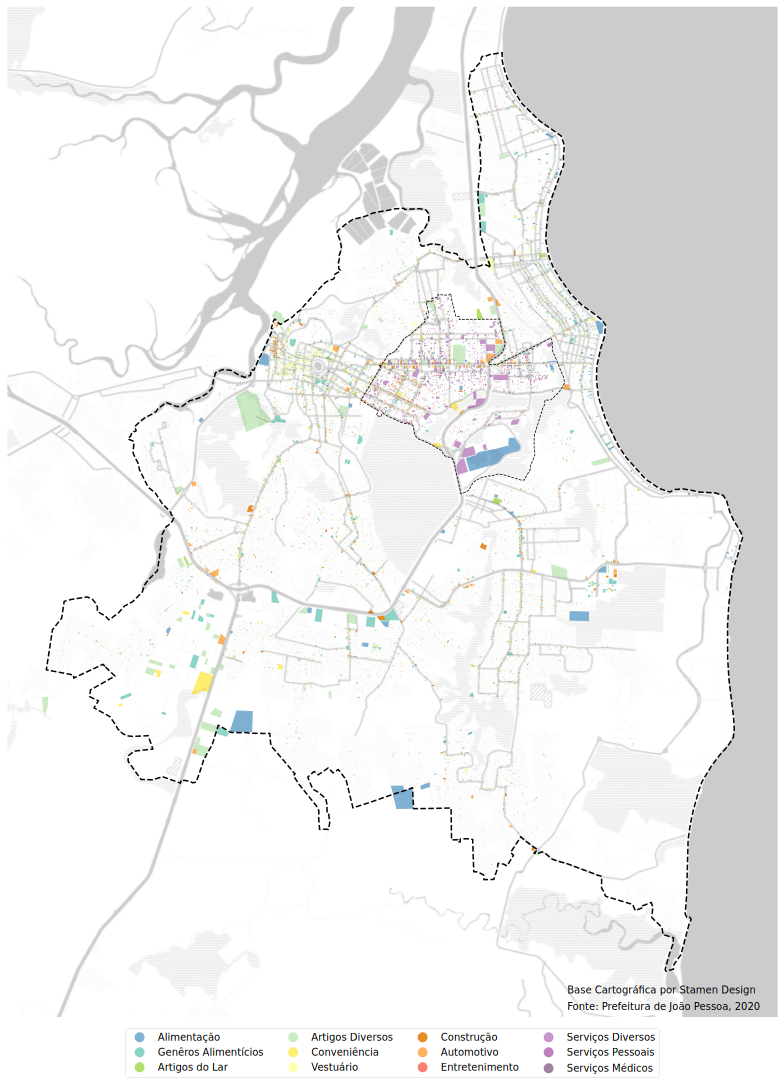

In [121]:
plot_categorical(lotes, 'classifica', [limite_mun, recorte_menor], 'comercio_cidade.pdf', (560, 27), (560, 10), 13)
plt.show()

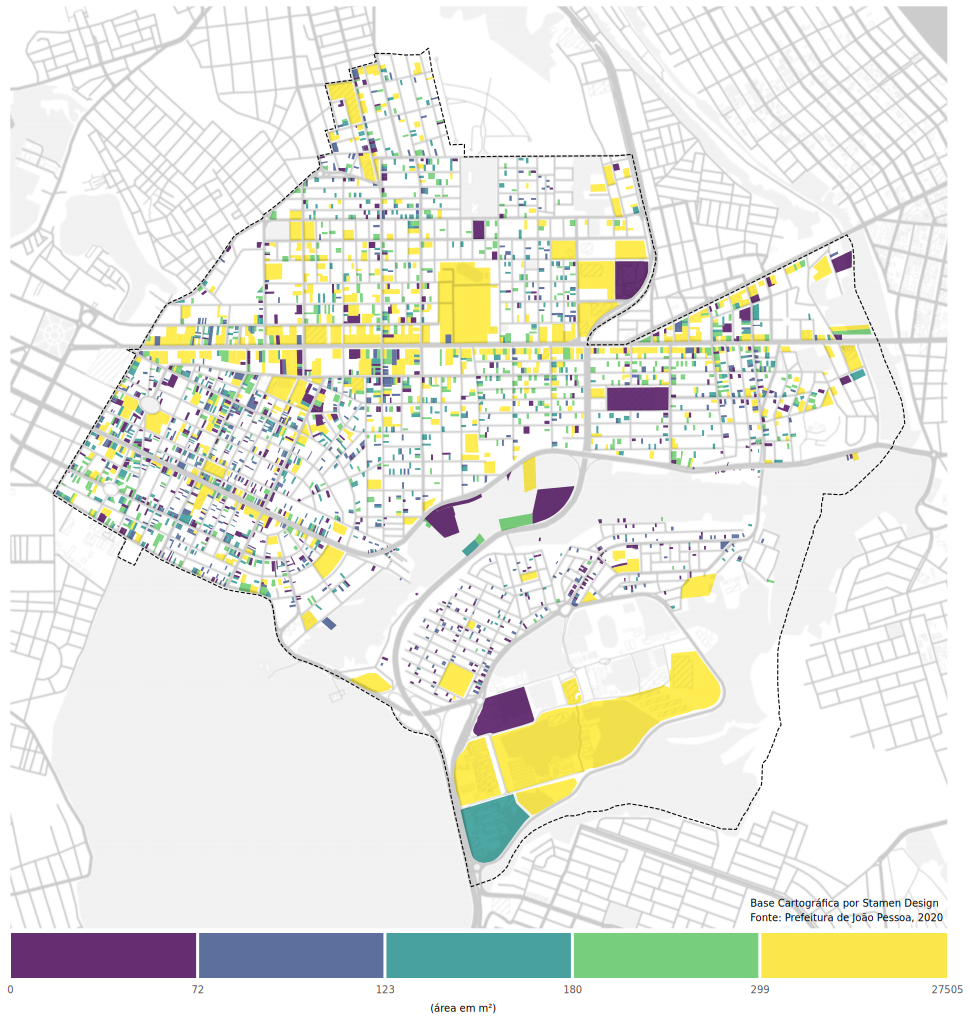

In [123]:
column = 'Area_Predi'
fig, ax = plt.subplots()
ax.set_facecolor('none')
ax.set_axis_off()
k = 5
alpha=0.8


def get_bins(df, column, n_bins):
    min_v = df[column].min()
    max_v = df[column].max()
    array = []
    
    for i in range(n_bins+1):
        step = max_v/n_bins
        array.append(int(round(step*i, 0)))
    
    return array

def get_quantiles(df, column, k=5):
    step = 1/k
    quantiles = []
    for i in range(k+1):
        quantile_at_step = df[column].quantile(step*i)
        quantiles.append(quantile_at_step)
    return quantiles

#quadras.plot(ax=ax, facecolor='#ffffff', edgecolor='#cccccc', linewidth=0.1)
plot = lotes_recorte.plot(ax=ax, 
                          column=column, 
                          cmap='viridis',
                          linewidth=0,
                          scheme='quantiles', 
                          k=k,
                          edgecolor='#FFFFFF',
                          alpha=alpha)
cmap = mpl.cm.viridis
divider = make_axes_locatable(ax)
bins = get_quantiles(lotes_recorte, column, k=k)

norm = mpl.colors.BoundaryNorm(bins, cmap.N)



cax = divider.append_axes("bottom", size="5%", pad=0.05)

cb = mpl.colorbar.ColorbarBase(ax=cax,
                               cmap=cmap,
                               norm=norm,
                               spacing='uniform',
                               orientation='horizontal',
                               extend='neither',
                               ticks=bins,
                               drawedges=True,
                               alpha=alpha)



recorte_plot = recorte_maior.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.1, linestyle='--')



# The figure and axes background must be made transparent.


ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerBackground, zoom=16, alpha = 0.2, attribution="")
cb.outline.set_edgecolor('#ffffff')
cb.dividers.set_linewidth(3)
cax.tick_params(color='none')

plt.annotate('Fonte: Prefeitura de João Pessoa, 2020', (0,0), (740, 60), xycoords='axes fraction', textcoords='offset points', va='center')
plt.annotate('Base Cartográfica por Stamen Design', (0,0), (740, 75), xycoords='axes fraction', textcoords='offset points', va='center')
plt.annotate('(área em m²)', (0,0), (420, -30), xycoords='axes fraction', textcoords='offset points', va='center')

plt.tight_layout()
operator_t.MULTIPLY.patch_artist(plot)  # Use additive blending.
plt.savefig('varejo_area_construida.pdf', bbox_inches='tight')
plt.show()